In [1]:
import pandas as pd
# from matplotlib import pyplot
import numpy as np
import seaborn as sns
import math
import datetime
import pickle
import joblib
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
# model_rfr_hpo = joblib.load('savemodel_rfr_ftr_hpo.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')
# model_rft = joblib.load('savemodel_rf.sav')


model_etr = joblib.load('savemodel_etr.sav')
model_etr_hpov = joblib.load('savemodel_etr_hpov.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')
model_dtr_hpov = joblib.load('savemodel_dtr_hpov.sav')


model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [2]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [3]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [4]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [5]:
x_pre = imputer.transform(dfpre)

In [6]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [7]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [8]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001


In [9]:
# dfpre["True North Wind Direction"] =  180 +  np.rad2deg(np.arctan((dfpre["eastwind"])/(dfpre["northwind"])))

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

# dfpre["True North Wind Direction"] = np.where(dfpre["True North Wind Direction"] > 0, 180 + dfpre["True North Wind Direction"] , 180 - dfpre["True North Wind Direction"])

# if dfpre["True North Wind Direction"]<0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]
# elif dfpre["True North Wind Direction"]>0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]

In [10]:
# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))


# 
condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [11]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [12]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,251.408180,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,254.458891,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,259.749663,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,266.724504,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [13]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [14]:
# Exclude data for the month of June to check the model's forecasting performance 

dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

# Extract information of a journey from a single day

koege_dep = df[df['Time'].dt.strftime('%Y-%m-%d %H:%M:%S') == '2021-05-31 23:00:00']
koege_arr = dfdate6[dfdate6['Time'].dt.strftime('%Y-%m-%d') == '2021-06-01']

# Drop the departure time for next trip

koege_arr2 = koege_arr.drop(koege_arr.index[14])

# To gain information for a single trip from Koege to Ronne

ronne_arr = koege_arr.drop(koege_arr.index[4:15])

dfday6 = pd.concat([koege_dep,koege_arr2])
dfone6 = pd.concat([koege_dep,ronne_arr])

# # For Qgis Single Journey
# dfday6.to_csv("AIS_01_06_21_koegeronne.csv")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            3506 non-null   int64         
 1   Time                                  3506 non-null   datetime64[ns]
 2   LON                                   3506 non-null   float64       
 3   LAT                                   3506 non-null   float64       
 4   Temperature above oceans              3506 non-null   float64       
 5   Air density above oceans              3405 non-null   float64       
 6   Max wave height                       3152 non-null   float64       
 7   Swell period                          3152 non-null   float64       
 8   Wind wave period                      3152 non-null   float64       
 9   Wave period                           3152 non-null   float64       
 10  

Add test data for 3 months into validation data

In [16]:
# Data Splitting

from sklearn.model_selection import train_test_split

# Dropping some feature can be done here to (possibly) increase the model's performance 
x_train,x_test,y_train,y_test = train_test_split(df.drop(['SOG']
                                                                 ,axis=1)
                                                                ,df.SOG,test_size=0.2,random_state=42)

In [17]:
df_test = pd.concat([x_test,y_test],axis=1)

In [18]:
# Extract three months of data from the test datasets

# Test with more data
dfdate1 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-01']
dfdate2 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-02']
dfdate3 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-03']
dfdate4 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-04']
dfdate5 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-05']
# ##########################################################################

dfdate7 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-07']
dfdate8 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-08']
dfdate9 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-09']
dfdate10 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-10']
dfdate11 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-11']
dfdate12 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-12']



# Concatenate 6 months data into df_ship

# df_months6 = pd.concat([dfdate7,dfdate8,dfdate9,dfdate10,dfdate11,dfdate12])

# Test section with more data 

df_months6 = pd.concat([dfdate1,dfdate2,dfdate3,dfdate4,dfdate5,dfdate7,dfdate8,dfdate9,dfdate10,dfdate11,dfdate12])



In [19]:
df_ship = df_months6.drop(['Unnamed: 0','LON','LAT','Time','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)
df_ship.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction,SOG
702,273.350830,1.639553,5.229636,3.234901,4.094504,277.717895,0.854533,0.560547,0.642914,4.834130,...,167.639484,106.755485,100.890698,23.424774,57.035614,0.105747,7.899833,296.750531,177.634530,17.796529
425,277.373535,1.363195,4.333393,2.725380,3.808491,278.187500,0.717416,0.493626,0.452545,5.385540,...,6.853836,57.056116,81.702482,162.263868,121.675917,0.068111,6.477506,271.208773,155.118725,18.973217
7305,275.485107,1.207072,5.079647,2.175282,5.028988,281.692139,0.642756,0.637711,0.065796,5.470698,...,63.460148,151.271969,50.719773,118.366245,50.614403,0.208269,2.273218,235.776237,201.044120,18.584076
302,274.433594,2.649884,4.345334,4.285193,4.287695,277.633911,1.368544,0.258740,1.343628,5.289444,...,81.400359,144.552992,45.264404,96.999874,96.106695,0.256832,10.366420,20.462256,186.385110,17.367918
615,275.730713,1.330918,3.942446,3.345863,3.439272,277.380493,0.703928,0.279053,0.645996,5.379842,...,5.408478,34.711324,122.409087,171.729094,165.529997,0.028694,6.797408,286.243468,66.123666,18.056660


In [20]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [21]:
df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [22]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truenorthcurrentdir','truenorthwinddir'],axis=1)

In [23]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)


KNNImputer(n_neighbors=50)

In [24]:
X = imputer.transform(df_ship2)

In [25]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [26]:
x_months6 = df_ship2tr.drop(['sog'],axis=1)
y_months6 = df_ship2tr.sog

In [27]:
print("Amount of the test dataset is:",len(x_months6))

Amount of the test dataset is: 702


Special Section

In [28]:
# # Check model performance for one trip
# # PLEASE COMMMENT WHEN DONE !!!

# dfdate6 = dfone6

Exporting File

In [29]:
# df.to_csv('June_update.csv')

Measure performance in one month

In [30]:
dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
dfdate6.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.782313,100.989288,164.871808,15.554049,66.843493,57.268527,0.144914,10.248966,21.771601,184.345879
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,96.934816,108.737155,153.650411,11.071672,60.455881,51.313932,0.246220,11.364678,25.671971,199.414773
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,97.525758,114.910729,153.031589,16.281358,57.086511,46.894106,0.284315,12.666946,32.436488,199.442652
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,106.941521,123.568984,153.643227,69.175152,55.507286,56.527939,0.300428,13.386999,50.510505,189.415252
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,227.680837,26.476633,41.766758,158.632374,159.050718,167.192888,0.262897,12.053293,74.157471,180.552404


In [31]:
dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [32]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

dfdate6 = dfdate6[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]


# dfdate6 = dfdate6[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [33]:
stats2 = dfdate6['curspeed'].value_counts()

In [34]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)


In [35]:
imputer.fit(dfdate6)

KNNImputer(n_neighbors=50)

In [36]:
xdate = imputer.transform(dfdate6)

In [37]:
dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [38]:
# x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
# y_date = dfdate6tr.sog

x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date = dfdate6tr.sog

In [39]:
print(f"Amount of the test dataset is {len(x_date)}")

Amount of the test dataset is 322


In [40]:
dfdate6.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,sog,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,truenorthwinddir,truenorthcurrentdir
count,322.000000,287.000000,305.000000,287.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,287.000000,322.000000,322.000000
mean,287.133146,3.411435,287.261956,0.665559,5.282713,17.449699,197.436423,189.432992,5.832751,0.092478,86.173628,86.811052,95.744646,193.881748,155.282564
std,6.306975,1.018301,4.927599,0.572845,0.162420,3.069944,86.327689,88.499255,3.020207,0.068917,62.588681,59.359251,63.892090,89.816472,102.716811
min,269.606903,1.915993,275.485352,0.073242,4.754639,5.224523,82.664990,79.551648,0.441768,0.002006,0.565115,1.295289,0.200645,3.207821,0.112383
25%,285.292786,2.656420,286.814697,0.254164,5.199718,16.568861,103.569971,101.685445,3.442231,0.043318,24.875738,28.600108,29.381058,120.064906,83.669063
50%,289.505615,3.125275,289.625977,0.431268,5.290842,18.413643,193.360899,125.125521,5.528616,0.073482,82.212973,79.271353,104.919772,193.709354,129.304190
75%,291.391602,3.919880,290.497070,0.836488,5.381292,19.421633,283.259801,279.238872,7.569939,0.123647,149.107733,146.039105,159.782560,279.768652,249.619550
max,294.685303,6.291378,292.665649,2.565230,5.657671,21.031230,319.851509,304.969531,13.386999,0.417155,179.309007,179.405213,179.699225,357.291804,359.450078


Reverse Modelling Test 

Concatenate test and validation data 

In [41]:
x_date_c = pd.concat([x_date,x_months6])
y_date_c = pd.concat([y_date,y_months6])

In [42]:
def evaluate(model, features_x, labels_y):
    from sklearn.model_selection import cross_val_score

    score_r2 = cross_val_score(model,features_x,labels_y,
                           scoring='r2',cv=10)
    rsquared = score_r2.mean()
    stadev_rsquared = score_r2.std()
    max_rsquared = score_r2.max()
    min_rsquared = score_r2.min()

    score_expVar = cross_val_score(model,features_x,labels_y,
                           scoring='explained_variance',cv=10)
    expVar = score_expVar.mean()
    stadev_expVar = score_expVar.std()
    max_expVar = score_expVar.max()
    min_expVar = score_expVar.min()

    score_MAE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_mean_absolute_error',cv=10)
    MAE = -score_MAE.mean()
    stadev_MAE = score_MAE.std()
    max_MAE = -score_MAE.max()
    min_MAE = -score_MAE.min()

    score_MAD = cross_val_score(model,features_x,labels_y,
                           scoring='neg_median_absolute_error',cv=10)
    MAD = -score_MAD.mean()
    stadev_MAD = score_MAD.std()
    max_MAD = -score_MAD.max()
    min_MAD = -score_MAD.min()



    score_RMSE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_root_mean_squared_error',cv=10)
    RMSE = -score_RMSE.mean()
    stadev_RMSE = score_RMSE.std()
    max_RMSE = -score_RMSE.max()
    min_RMSE = -score_RMSE.min()


    print(f"Model Performance of {model}")
    print(f"R^2 = {rsquared:0.4f}, std = {stadev_rsquared:0.4f}, max = {max_rsquared:0.4f}, min = {min_rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}, std = {stadev_expVar:0.4f}, max = {max_expVar:0.4f}, min = {min_expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}, std = {stadev_MAE:0.4f}, max = {max_MAE:0.4f}, min = {min_MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}, std = {stadev_RMSE:0.4f}, max = {max_RMSE:0.4f}, min = {min_RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}, std = {stadev_MAD:0.4f}, max = {max_MAD:0.4f}, min = {min_MAD:0.4f}\n")

    return score_r2,score_expVar,score_MAE,score_MAD,score_RMSE    

RFR evaluation

In [43]:
r2_rf,expVar_rf,MAE_rf,RMSE_rf,MAD_rf = evaluate(model_rfr_ftr,x_date,y_date)

Model Performance of RandomForestRegressor(random_state=42)
R^2 = 0.7562, std = 0.2182, max = 0.9392, min = 0.3669
explained Variance = 0.7865, std = 0.1911, max = 0.9397, min = 0.4465
MAE = 0.9594, std = 0.4931, max = 0.5719, min = 2.3230
RMSE = 1.3125, std = 0.7283, max = 0.6874, min = 3.2810
MAD = 0.7261, std = 0.2845, max = 0.2943, min = 1.4170



In [44]:
r2_rfo,expVar_rfo,MAE_rfo,RMSE_rfo,MAD_rfo = evaluate(model_rfr_hpov,x_date,y_date)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 = 0.7519, std = 0.2245, max = 0.9362, min = 0.3532
explained Variance = 0.7862, std = 0.1896, max = 0.9374, min = 0.4354
MAE = 0.9581, std = 0.4977, max = 0.5610, min = 2.3235
RMSE = 1.3207, std = 0.7349, max = 0.6768, min = 3.3163
MAD = 0.7263, std = 0.2968, max = 0.1940, min = 1.3525



In [45]:
r2_et,expVar_et,MAE_et,RMSE_et,MAD_et = evaluate(model_etr,x_date,y_date)

Model Performance of ExtraTreesRegressor(random_state=42)
R^2 = 0.7970, std = 0.1582, max = 0.9446, min = 0.4831
explained Variance = 0.8234, std = 0.1285, max = 0.9478, min = 0.6018
MAE = 0.9057, std = 0.3844, max = 0.5302, min = 1.9772
RMSE = 1.2205, std = 0.5432, max = 0.6185, min = 2.6923
MAD = 0.6861, std = 0.2689, max = 0.3620, min = 1.3711



In [46]:
r2_eto,expVar_eto,MAE_eto,RMSE_eto,MAD_eto = evaluate(model_etr_hpov,x_date,y_date)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 = 0.8095, std = 0.1467, max = 0.9451, min = 0.5675
explained Variance = 0.8324, std = 0.1246, max = 0.9468, min = 0.6294
MAE = 0.8844, std = 0.3895, max = 0.5277, min = 1.9626
RMSE = 1.1892, std = 0.5493, max = 0.6156, min = 2.6718
MAD = 0.6730, std = 0.2809, max = 0.2382, min = 1.3678



In [47]:
r2_dt,expVar_dt,MAE_dt,RMSE_dt,MAD_dt = evaluate(model_dtr_ftr,x_date,y_date)

Model Performance of DecisionTreeRegressor()
R^2 = 0.6751, std = 0.2564, max = 0.9079, min = 0.1596
explained Variance = 0.6412, std = 0.3267, max = 0.9143, min = -0.1853
MAE = 1.0668, std = 0.3274, max = 0.7558, min = 1.9111
RMSE = 1.4482, std = 0.6275, max = 0.7946, min = 2.9538
MAD = 0.7627, std = 0.2891, max = 0.3940, min = 1.3278



In [48]:
r2_dto,expVar_dto,MAE_dto,RMSE_dto,MAD_dto = evaluate(model_dtr_hpov,x_date,y_date)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 = 0.7205, std = 0.1973, max = 0.9309, min = 0.3210
explained Variance = 0.7420, std = 0.1815, max = 0.9387, min = 0.3733
MAE = 1.0421, std = 0.4238, max = 0.6452, min = 2.1729
RMSE = 1.4599, std = 0.6413, max = 0.8394, min = 3.0618
MAD = 0.7360, std = 0.3001, max = 0.4094, min = 1.5088



In [49]:
r2_mlr,expVar_mlr,MAE_mlr,RMSE_mlr,MAD_mlr = evaluate(model_mlr_ftr,x_date,y_date)

Model Performance of LinearRegression()
R^2 = 0.3935, std = 0.8308, max = 0.8044, min = -2.0209
explained Variance = 0.4096, std = 0.8268, max = 0.8377, min = -2.0009
MAE = 1.4308, std = 0.3603, max = 1.0765, min = 2.3214
RMSE = 1.9116, std = 0.9133, max = 1.2116, min = 4.4828
MAD = 1.2237, std = 0.2026, max = 0.9489, min = 1.5400



Experiment on amount of data effectiveness

In [50]:
print(f"Combined data length of June data + 6 months is {len(x_date_c)}")

Combined data length of June data + 6 months is 1024


In [51]:
# r2_rfc,expVar_rfc,MAE_rfc,RMSE_rfc,MAD_rfc = evaluate(model_rfr_ftr,x_date_c,y_date_c)

In [52]:
# r2_rfco,expVar_rfco,MAE_rfco,RMSE_rfco,MAD_rfco = evaluate(model_rfr_hpov,x_date_c,y_date_c)

In [53]:
# r2_etc,expVar_etc,MAE_etc,RMSE_etc,MAD_etc = evaluate(model_etr,x_date_c,y_date_c)

In [54]:
# r2_etco,expVar_etco,MAE_etco,RMSE_etco,MAD_etco = evaluate(model_etr_hpov,x_date_c,y_date_c)

In [55]:
# r2_dtc,expVar_dtc,MAE_dtc,RMSE_dtc,MAD_dtc = evaluate(model_dtr_ftr,x_date_c,y_date_c)

In [56]:
# r2_dtco,expVar_dtco,MAE_dtco,RMSE_dtco,MAD_dtco = evaluate(model_dtr_hpov,x_date_c,y_date_c)

In [57]:
# r2_mlrc,expVar_mlrc,MAE_mlrc,RMSE_mlrc,MAD_mlrc = evaluate(model_mlr_ftr,x_date_c,y_date_c)

In [58]:
# fit a y = mx + c for the predicted vs actual  

from numpy import arange
from scipy.optimize import curve_fit

# plt.figure(figsize=(5,5))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

def pred_plot(model,modelname,test_feature,test_label):
    
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    from sklearn.linear_model import LinearRegression
    predict = label_predict(model,test_feature)

    from sklearn.metrics import r2_score

    print(r2_score(test_label, predict))

    # choose the input and output variables
    x, y = test_label, predict

    reg = LinearRegression().fit(x.values.reshape(-1,1) , y)
    b = reg.intercept_
    m = reg.coef_[0]
    plt.axline(xy1=(0, b), slope=m, label=rf'$y = {m:.1f}x {b:+.1f}$',color = 'r', ls ='--')

    # curve fit
    popt, _ = curve_fit(objective, x, y)

    # summarize the parameter values
    a, b = popt
    print('y = %.1f * x + %.1f' % (a, b ))

    # plot input vs output
    
    plt.scatter(x, y,edgecolors='black')
    
    # define a sequence of inputs between the smallest and largest known inputs
    
    x_line = arange(min(x), max(x), 1)
        
    # calculate the output for the range
    
    y_line = objective(x_line, a, b)
    
    # create a line plot for the mapping function
    
    # plt.plot(x_line, y_line, color='red')
    plt.xlabel(r'Predicted SOG [$m/s$]', fontsize=13)
    plt.ylabel(r'Actual SOG [$m/s$]', fontsize=13)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(rf"{modelname}", fontsize=14)
    plt.xlim(0,25)
    plt.ylim(0,25)
    plt.legend()



0.7930691573886957
y = 0.9 * x + 1.9
0.8451332064434847
y = 0.8 * x + 2.3


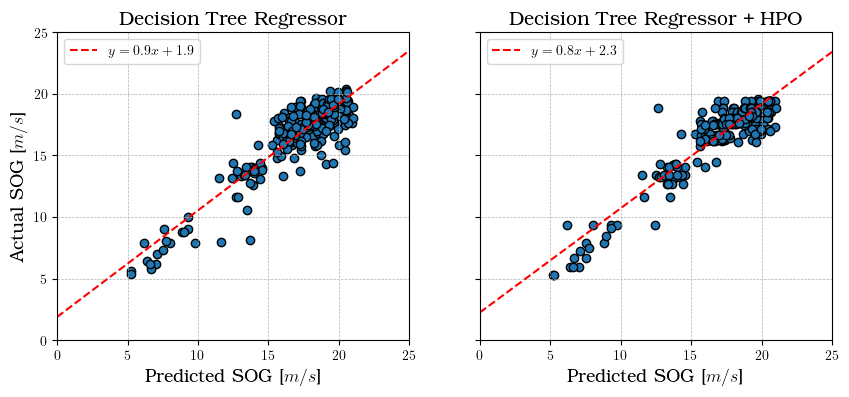

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_ftr,'Decision Tree Regressor',x_date,y_date)
plt.sca(axes[1])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date,y_date)
plt.ylabel("")
plt.show()

0.8641250686489151
y = 0.8 * x + 2.2
0.8669620381079686
y = 0.8 * x + 2.3


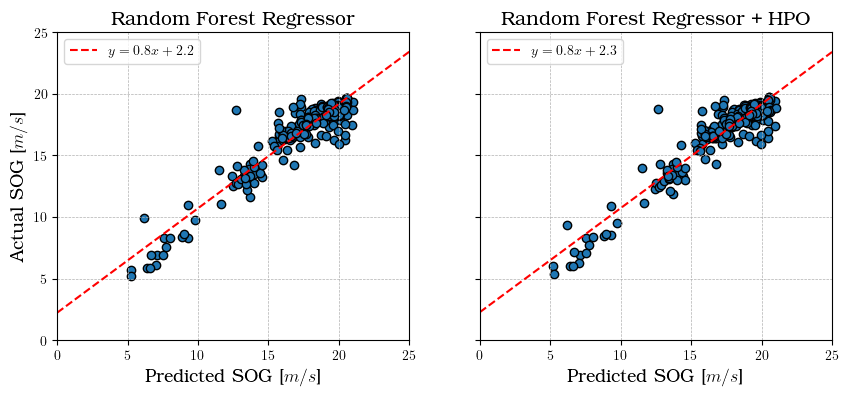

In [60]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_rfr_ftr,'Random Forest Regressor',x_date,y_date)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date,y_date)
plt.ylabel("")
plt.show()

0.8743301165173356
y = 0.9 * x + 2.2
0.8731763195782185
y = 0.8 * x + 2.3


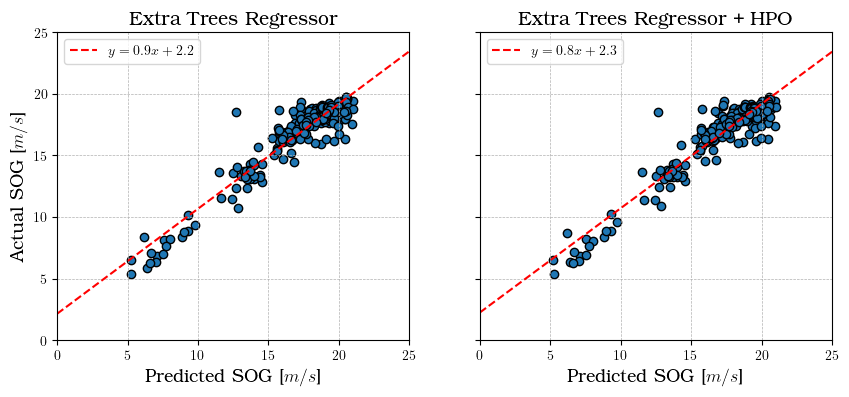

In [61]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_etr,'Extra Trees Regressor',x_date,y_date)
plt.sca(axes[1])
pred_plot(model_etr_hpov,'Extra Trees Regressor + HPO',x_date,y_date)
plt.ylabel("")
plt.show()

Evaluation using Cross Validation

<Figure size 500x300 with 0 Axes>

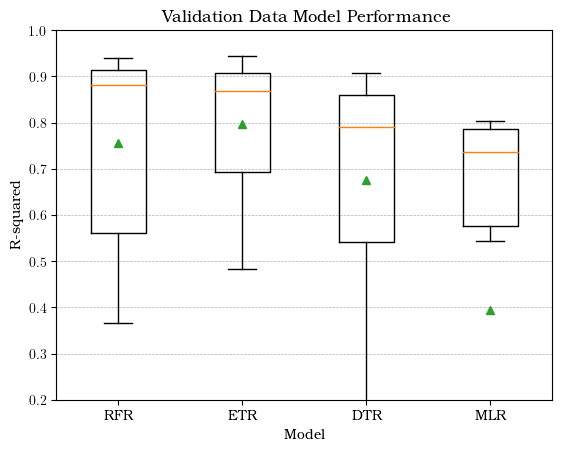

In [62]:
scores_test = [r2_rf,r2_et,r2_dt,r2_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("Validation Data Model Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0.2,1.0)
plt.boxplot(scores_test,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR','MLR'])
plt.show()

<Figure size 500x300 with 0 Axes>

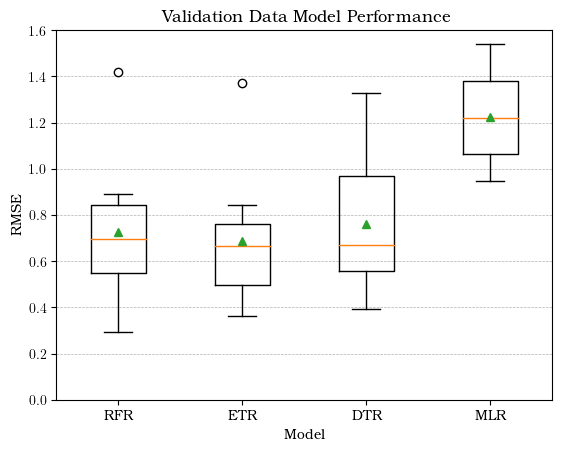

In [63]:
scores_test = [-RMSE_rf,-RMSE_et,-RMSE_dt,-RMSE_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("Validation Data Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0,1.6)
plt.boxplot(scores_test,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR','MLR'])
plt.show()

Optimization comparison

<Figure size 500x300 with 0 Axes>

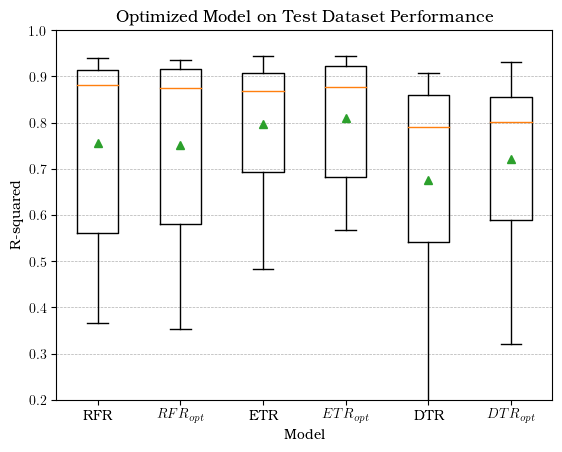

In [64]:
scores_opt = [r2_rf,r2_rfo,r2_et,r2_eto,r2_dt,r2_dto]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Optimized Model on Test Dataset Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.ylim(0.2,1.0)
plt.yscale('linear')
ax.boxplot(scores_opt,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                    r'ETR', r'$ETR_{opt}$',
                    r'DTR',r'$DTR_{opt}$'])
plt.show()

<Figure size 500x300 with 0 Axes>

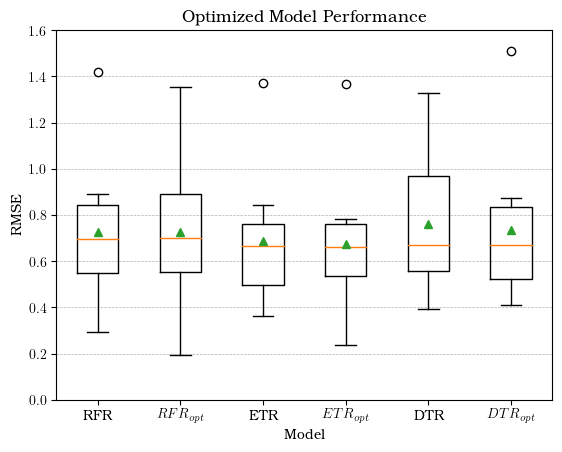

In [65]:
rmse_opt = [-RMSE_rf,-RMSE_rfo,-RMSE_et,-RMSE_eto,-RMSE_dt,-RMSE_dto]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Optimized Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0,1.6)
ax.boxplot(rmse_opt,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                    r'ETR', r'$ETR_{opt}$',
                    r'DTR',r'$DTR_{opt}$'])
plt.show()

In [66]:
# scores_opt = [r2_rf,r2_rfc,r2_et,r2_etc,r2_dt,r2_dtc]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Impact of amount of data")
# plt.ylabel("R-squared")
# plt.xlabel("Model")
# plt.ylim(0.2,1.0)
# plt.yscale('linear')
# ax.boxplot(scores_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'RFR', r'$RFR_{6mths}$',
#                     r'ETR', r'$ETR_{6mths}$',
#                     r'DTR',r'$DTR_{6mths}$'])
# plt.show()

In [67]:
# rmse_opt = [-RMSE_rf,-RMSE_rfc,-RMSE_et,-RMSE_etc,-RMSE_dtc,-RMSE_dtc]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Impact of Amount of Data")
# plt.ylabel("RMSE")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0,1.6)
# ax.boxplot(rmse_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'RFR', r'$RFR_{6mths}$',
#                     r'ETR', r'$ETR_{6mths}$',
#                     r'DTR',r'$DTR_{6mths}$'])
plt.show()

In [68]:
# define the true objective function
def objective(x, a, b, c):
	return a * x + b * x**2 + c

STW Calculation

In [69]:
# def label_predict(model,test_features):
#     predictions = model.predict(test_features)
#     return predictions

# ydate_pred = label_predict(model_etr_hpov,x_date_c)
 
# dfprog_sog = pd.Series(y_date_c,name="sog_act").to_frame()
# dfprog_sog["sog_pred"] = ydate_pred
# dfprog_sog["gamma"] = pd.concat([dfdate6tr["truenorthcurrentdir"],df_months6["True North Current Direction"]])
# dfprog_sog["nwinddir"] = pd.concat([dfdate6tr["truenorthwinddir"],df_months6["True North Wind Direction"]])

# print(dfprog_sog)

In [70]:
# dfprog = pd.concat([x_date_c,dfprog_sog],axis=1)
# dfprog.head(n=10)

In [71]:
def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

ydate_pred = label_predict(model_etr_hpov,x_date)
 
dfprog_sog = pd.Series(y_date,name="sog_act").to_frame()
dfprog_sog["sog_pred"] = ydate_pred
dfprog_sog["gamma"] = dfdate6tr["truenorthcurrentdir"]
dfprog_sog["nwinddir"] = dfdate6tr["truenorthwinddir"]

print(dfprog_sog)

        sog_act   sog_pred       gamma    nwinddir
119   18.998906  18.378565  184.345879   21.771601
120   19.334278  18.451394  199.414773   25.671971
121   18.911047  18.381229  199.442652   32.436488
122   13.854933  14.118469  189.415252   50.510505
126    9.305198  10.229631  180.552404   74.157471
...         ...        ...         ...         ...
7413  19.072622  18.393094  104.966166  110.959927
7414  17.696584  17.721502   86.330174  126.837339
7415  15.963630  16.351225   83.486098  119.018621
7418   8.988086   8.852668   89.745593  140.723377
7419  17.672769  17.400909   15.792214  143.902554

[322 rows x 4 columns]


In [72]:
dfprog = pd.concat([x_date,dfprog_sog],axis=1)
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act,sog_pred,gamma,nwinddir
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,100.989288,164.871808,57.268527,18.998906,18.378565,184.345879,21.771601
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,108.737155,153.650411,51.313932,19.334278,18.451394,199.414773,25.671971
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,114.910729,153.031589,46.894106,18.911047,18.381229,199.442652,32.436488
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,123.568984,153.643227,56.527939,13.854933,14.118469,189.415252,50.510505
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,26.476633,41.766758,167.192888,9.305198,10.229631,180.552404,74.157471
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,49.650197,36.203894,119.939682,20.935741,17.407156,184.264563,72.289134
128,275.499359,5.927387,287.026093,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,11.124505,16.745666,176.253205,12.419853,11.395116,182.129556,60.000273
130,276.370789,5.959699,285.581279,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,121.750507,148.640604,54.778275,20.447721,16.317278,275.295245,68.405148
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,156.811217,154.901600,41.385363,18.702889,16.068425,187.199243,84.710374
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,1.584058,10.961510,159.775304,16.155258,16.096665,281.621166,89.075598


In [73]:
# Conversion of predicted SOG to m/s

dfprog["vgms"] = dfprog["sog_pred"]/1.9438

# Conversion of actual SOG to m/s

dfprog["vgms_act"] = dfprog["sog_act"]/1.9438

In [74]:
# Conversion of the angles to radian

rad_gamma = np.deg2rad(dfprog["gamma"])
rad_cog = np.deg2rad(dfprog["heading"])

In [75]:
# Calculation of the predicted x-component of SOG

dfprog["vgx"] = dfprog["vgms"] * np.sin(rad_cog)
dfprog["vcx"] = dfprog["curspeed"] * np.sin(rad_gamma)
dfprog["stw_x"] = (dfprog["vgx"] - dfprog["vcx"])

# Calculation of the actual x-component of SOG

dfprog["vgx_act"] = dfprog["vgms_act"] * np.sin(rad_cog)
dfprog["stw_x_act"] = (dfprog["vgx_act"] - dfprog["vcx"])


In [76]:
# Calculation of the predicted y-component of SOG 

dfprog["vgy"] = dfprog["vgms"] * np.cos(rad_cog)
dfprog["vcy"] = dfprog["curspeed"] * np.cos(rad_gamma)
dfprog["stw_y"] = (dfprog["vgy"] - dfprog["vcy"])

# Calculation of the actual y-component of SOG

dfprog["vgy_act"] = dfprog["vgms_act"] * np.cos(rad_cog)
dfprog["stw_y_act"] = (dfprog["vgy_act"] - dfprog["vcy"])


In [77]:
# For the prediction

dfprog["vwms_p"] = np.sqrt(dfprog["stw_x"]**2 + dfprog["stw_y"]**2)
dfprog["stw_pred"] = (dfprog["vwms_p"]*1.9438)

# For the actual data

dfprog["vwms_a"] = np.sqrt(dfprog["stw_x_act"]**2 + dfprog["stw_y_act"]**2)
dfprog["stw_act"] = (dfprog["vwms_a"]*1.9438)

In [78]:
dfprog = dfprog.drop(['vgms','vgx','vcx','stw_x',
                      'vgy','vcy','stw_y',
                      'vwms_p'],axis=1)
# #df_ship.head(n=5)
# dfprog.head(n=10)

In [79]:
dfprog.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,...,gamma,nwinddir,vgms_act,vgx_act,stw_x_act,vgy_act,stw_y_act,stw_pred,vwms_a,stw_act
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,...,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,287.133146,3.400343,287.256948,0.661506,5.282713,197.436423,189.432992,5.832751,0.092478,86.173628,...,155.282564,193.881748,8.977106,0.070666,0.042628,-0.274650,-0.274257,17.043394,8.984745,17.464548
std,6.306975,0.965020,4.797442,0.541832,0.162420,86.327689,88.499255,3.020207,0.068917,62.588681,...,102.716811,89.816472,1.579352,8.784950,8.793543,2.465324,2.468326,2.770357,1.587188,3.085176
min,269.606903,1.915993,275.485352,0.073242,4.754639,82.664990,79.551648,0.441768,0.002006,0.565115,...,0.112383,3.207821,2.687789,-10.627792,-10.611452,-6.280013,-6.297111,5.320474,2.661667,5.173749
25%,285.292786,2.692099,286.832031,0.272528,5.199718,103.569971,101.685445,3.442231,0.043318,24.875738,...,83.669063,120.064906,8.523953,-9.160175,-9.168896,-1.806276,-1.796571,16.739468,8.538468,16.597074
50%,289.505615,3.160003,289.004578,0.474936,5.290842,193.360899,125.125521,5.528616,0.073482,82.212973,...,129.304190,193.709354,9.473013,3.436768,3.412995,-0.796771,-0.775535,18.113208,9.471227,18.410172
75%,291.391602,3.764453,290.458008,0.788779,5.381292,283.259801,279.238872,7.569939,0.123647,149.107733,...,249.619550,279.768652,9.991580,9.352716,9.289309,1.568646,1.571020,18.620016,10.007329,19.452246
max,294.685303,6.291378,292.665649,2.565230,5.657671,319.851509,304.969531,13.386999,0.417155,179.309007,...,359.450078,357.291804,10.819647,10.737517,10.744760,5.697832,5.878790,19.630391,10.855991,21.101875


Integration of Holtrop Mennen Estimations to calculate Resistance and consequently FOC

In [80]:
# Ship Information, that are readily available in ship specification

loa = 158 # ship overall length
lwl = 144.8 # ship waterline length, m
lpp = 0.97*lwl # ship perpendicular length , m, according to information
B = 24.5 # Ship breadth, m
depth = 13.8 # Ship depth. m
T_n = 5.85 # Nominal max draught , m
# T_n = 5.7 # Nominal design draught , m
dwt = 5110 # ship dead weight , t
V_n = 17.7 # ship design speed, knots

# Environmental Constants

g = 9.805 # gravity, kg/ms^2 
rho_sea = 1025 # kg/m3
nu_sea = 0.00000118 # Dynamic viscosity of sea m^2/s
rho_air = 1.25 # density air 

# Any other additional ship parameters beyond here are approximated based on literature review.

Switch between actual and predicted here

In [81]:
# Convert STW to m/s, stw with only current correction

# dfprog['stw_pred_ms'] = dfprog['stw_pred'] / 1.94384

# Switch between actual and predicted here 

dfprog['stw_pred_ms'] = dfprog['stw_act'] / 1.94384

# Calculation for Block coefficient,C_b, according to Schneekluth and Bertram 1998
# Then Froude number is required

V_n = 17.7/1.94384
Fr_n = V_n / math.sqrt(g*lpp)
print(f"Froude Number {Fr_n:0.4f}")

C_b = -4.22 + 27.8*math.sqrt(Fr_n) - 39.1*Fr_n + 46.6*(Fr_n)**3
print(f"C_b {C_b:0.4f}")

Froude Number 0.2454
C_b 0.6451


In [82]:
# calculation for midship section coefficient, C_m according to Jensen from Birk

C_m = 1 / (1+(1-C_b)**3.5)
# C_m = 0.977 + 0.085*(C_b-0.6) # Charcalis
print(f"C_m {C_m:0.4f}")

# prismatic coefficient C_p can be calculated according to Biran

C_p = C_b/C_m 
print(f"C_p {C_p:0.4f}")

C_m 0.9741
C_p 0.6623


In [83]:
# Displacement calculation according to Barras 
# Use approximate value cd=0.35 according to Barras
# Readjust displacement to standard formula

# C_d = 0.35
# dsp = dwt/C_d # m^3

dsp = C_b * lwl * B * T_n

print(f"dsp {dsp:0.4f} m^3")

dsp 13388.8120 m^3


In [84]:
# coefficient c14 to account for stern shape according to holtrop mennen

C_stern = 10 # assume u shaped stern
c14 = 1 + 0.011*C_stern 
print(f"c14 {c14:0.4f}")

c14 1.1100


In [85]:
# Calculate length of run according to holtrop mennen

# lcb = -2/100 # according to Barras
lcb = -(0.44*Fr_n - 0.094) # according to Guldhammer and Harvald

# L in holtrop mennen is lwl

lr = lwl*(1-C_p+(0.06*C_p*lcb/(4*C_p-1)))
print(f"lr {lr:0.4f} m")

lr 48.8488 m


In [86]:
# now the (1+k1) can be calculated

k1a = 0.487118*c14*(B/lwl)**1.06806
k1b = (dfprog['draught']/lwl)**0.46106
k1c = (lwl/lr)**0.121563
k1d = (lwl**3/dsp)**0.36486
k1e = (1-C_p)**-0.604247

dfprog['k1_const'] = 0.93 + k1a*k1b*k1c*k1d*k1e
print(f"k1_const {dfprog['k1_const'].mean():0.4f}")


k1_const 1.2102


In [87]:
# Calculate Reynold number and Coefficient of Friction C_f. Here, the C_f will be dynamic and depend on the velocity of the ship

dfprog['Re'] =( dfprog['stw_pred_ms'] * lwl ) / nu_sea
dfprog['C_f'] = 0.075 / (np.log10(dfprog['Re']-2)**2)

print(f"Mean Reynold Number {dfprog['Re'].mean():0.2f}")
print(f"Mean Coefficient of friction {dfprog['C_f'].mean():0.6f}")

Mean Reynold Number 1102512169.68
Mean Coefficient of friction 0.000920


In [88]:
# Calculate the appendage area of bare hull S_bh
# Formula according to Holtrop Mennen

# Calculate the waterplane area coefficient 
# Formula according to Schneekluth and Bertram

C_wp = (1+2*C_b)/3
print(f"C_wp {C_wp:0.4f}")

# Calculate transverse bulb area A_bt, Transom area A_t and immersed midship section area A_m according to Kim 2019

# dfprog['A_m'] = B*dfprog['draught']*C_m
dfprog['A_m'] = dsp/(lpp*C_p)
dfprog['A_t'] = 0.051 * dfprog['A_m']
dfprog['A_bt'] = 0.085*dfprog['A_m'] # From approximation of Kracht78, Similar to Charcalis
# dfprog['A_bt'] = 0.08*dfprog['A_m'] # From approximation of Kracht78, Similar to Charcalis
print(f"A_m {dfprog['A_m'].mean():0.2f} m^2")
print(f"A_t {dfprog['A_t'].mean():0.2f} m^2")
print(f"A_bt {dfprog['A_bt'].mean():0.2f} m^2")

dfprog['sbh_a'] = lwl*(2*dfprog['draught']+B)*math.sqrt(C_m)
sbh_b = 0.453
sbh_c = 0.4425*C_b
sbh_d = 0.2862*C_m
dfprog['sbh_e'] = 0.003467*(B/dfprog['draught'])
sbh_f = 0.3696*C_wp
dfprog['sbh_g'] = 2.38*dfprog['A_bt']/C_b

dfprog['S_bh'] = dfprog['sbh_a']*(sbh_b+sbh_c-sbh_d+dfprog['sbh_e']+sbh_f)+dfprog['sbh_g']

print(f"S_bh {dfprog['S_bh'].mean():0.2f} m^2")

C_wp 0.7634
A_m 143.93 m^2
A_t 7.34 m^2
A_bt 12.23 m^2
S_bh 3843.36 m^2


In [89]:
# Calculate R_f

dfprog['R_f'] = 0.5 * rho_sea * (dfprog['stw_pred_ms'])**2 * dfprog['C_f'] * dfprog['S_bh'] * dfprog['k1_const']

print(f"Mean STW {dfprog['stw_pred'].mean():0.2f} kt")
print(f"Frictional Resistance {dfprog['R_f'].mean():0.2f} N")

Mean STW 17.04 kt
Frictional Resistance 181371.10 N


In [90]:
# Calculate resistance due to appendage

# Assume S_app
# Taken from Holtrop Mennen worked example
# S_app = 50 # m^2 

# Calculation of appendage area according to Hollenbach method, the formula is for twin screw ship

# Lower limit
S_app_lo = dfprog['S_bh'].mean()*(0.028+0.01*math.exp(-(lpp*T_n)/1000))

# Upper limit
S_app_hi = dfprog['S_bh'].mean()*(0.0325+0.045*math.exp(-(lpp*T_n)/1000))

print(f"S_app between {S_app_lo:.02f} and {S_app_hi:.02f} according to Hollenbach")

# The following appendage area are scaled from the picture of the ship
# Constant k here means (1+k_2) !

D_shaft = 0.55 # m, approx
l_shaft = 13.54 # m, approx

S_app_shaft = math.pi * D_shaft * l_shaft
k2_shaft = 2   

h_rudder = 4.06 #m, approx
B_rudder = 1.99 #m, approx
S_app_rudder = 2 * h_rudder * B_rudder #m, two side
k2_rudder = 3

h_skeg = 4.41 #m, approx
l_skeg = 26.23 #m, approx
S_app_skeg =  h_skeg * l_skeg #two side
k2_skeg = 0.75

S_app = S_app_shaft + S_app_rudder + S_app_skeg

k2_const = (k2_shaft*S_app_shaft + k2_rudder*S_app_rudder + k2_skeg*S_app_skeg)/S_app

print(f"Wetted area of hull is {dfprog['S_bh'].mean():0.2f}")
print(f"(1+k2) equivalent {k2_const:0.2f}")
print(f"Total Appendage area is {S_app:0.2f}")
# from holtrop mennen, take case of twin screw
# k2_const = 2.8

# Add resistance due to Bow Thrusters

d_th = 2.15 #m, approx

# Use formula from Hollenach
C_dth = 0.003 + 0.003*((10*d_th/T_n)-1)
# C_dth = 0.003 # The picture shows that the thruster are fairly parallel to midship area
# There are two bow thruster in this ship
dfprog['R_th'] = rho_sea*dfprog['stw_pred_ms']**2*math.pi*d_th**2*C_dth
print(f"Friction due to bow thrusters {dfprog['R_th'].mean():0.2f} N")

dfprog['R_app'] = (0.5 * rho_sea * (dfprog['stw_pred_ms'])**2 * (dfprog['C_f']) * S_app *k2_const) + 2*dfprog['R_th']
print(f"Mean STW {dfprog['stw_pred'].mean():0.2f} kt")
print(f"Appendage Friction {dfprog['R_app'].mean():0.2f} N")

S_app between 124.51 and 200.96 according to Hollenbach
Wetted area of hull is 3843.36
(1+k2) equivalent 1.17
Total Appendage area is 155.23
Friction due to bow thrusters 13660.07 N
Mean STW 17.04 kt
Appendage Friction 34415.25 N


In [91]:
# Calculate wave-making and wave-breaking resistance

print("Ratio check to ensure correct formula is used for Holtrop Mennen")
print(f"B/lwl = {B/lwl:0.2f}")
print(f"lwl^3/displacemt = {lwl**3/dsp:0.2f}")
print(f"C_p = {C_p:0.4f}")


c7 = B/lwl
T_fwd = dfprog['draught'] # See reasoning from Rakke16 
h_b = 0.4*T_n # must not exceed 0.6 T_f, here T_n = T_f (design), reasong and coefficient value taken from Rakke

# All formulas here are listed by Holtrop Mennen

dfprog['c3'] = 0.56 * dfprog['A_bt']**1.5 / (B*dfprog['draught']*(0.31*np.sqrt(dfprog['A_bt'])+T_fwd-h_b))
c2 = np.exp(-1.89*np.sqrt(dfprog['c3']))
dfprog['c5'] = 1 - 0.8*(dfprog['A_t']/(B*dfprog['draught']*C_m))
lambda_const = (1.446 * C_p) - 0.03*(lwl/B)
c16 = 8.07981*C_p - 13.8673*C_p**2 + 6.984388*C_p**3
dfprog['m_1'] = 0.0140407 * (lwl/dfprog['draught']) - 1.75254*(dsp**(1/3)/lwl) -  4.79323*(B/lwl) - c16
c15 = -1.69385

# Use dynamic Froude here to refect the actual resistance due to ship movement 

dfprog['Fr_n'] = dfprog['stw_pred_ms'] / math.sqrt(g*lpp)
# Updated formula use m_4
dfprog['m_4'] = 0.4 * c15 * np.exp(-0.034*dfprog['Fr_n']**-3.29)

i_e = 1 + 89*math.exp(-(lwl/B)**0.80856*(1-C_wp)**0.30484*(1-C_p-0.0225*lcb)**0.6367*(lr/B)**0.34574*((100*dsp)/lwl**3)**0.16302)
dfprog['c1'] = 2223105 * c7**3.78613 * (dfprog['draught']/B)**1.07961*(90-i_e)**-1.37565
d = -0.9

# Use updated formula with m4

dfprog['R_w'] = dfprog['c1']*c2*dfprog['c5']*dsp*g*rho_sea*np.exp(dfprog['m_1']*dfprog['Fr_n']**d+dfprog['m_4']*np.cos(lambda_const*dfprog['Fr_n']**-2))

print(f"Mean STW {dfprog['stw_pred'].mean():0.2f} kt")
print(f"Wave resistance {dfprog['R_w'].mean():0.2f} N")

Ratio check to ensure correct formula is used for Holtrop Mennen
B/lwl = 0.17
lwl^3/displacemt = 226.76
C_p = 0.6623
Mean STW 17.04 kt
Wave resistance 128744.96 N


In [92]:
# Calculate Resistance due to Bulbous Bow
# Calculate effect of forward sinkage h_f and local wave height at bow h_w

h_f = C_p * C_m * ((B*T_n)/lwl) * (136-316-3*dfprog['Fr_n'])*dfprog['Fr_n']**3
h_w = (i_e * dfprog['stw_pred_ms']**2) / (400*g)

P_b = 0.56*np.sqrt(dfprog['A_bt'])/(T_fwd-1.5*h_b)
dfprog['Fn_i'] = dfprog['stw_pred_ms'] / np.sqrt(g*(T_fwd-h_b-0.25*np.sqrt(dfprog['A_bt']))+0.15*dfprog['stw_pred_ms']**2)
# Updated Fn_i
# dfprog['Fn_i'] = dfprog['stw_pred_ms'] / np.sqrt(g*(T_fwd-h_b-0.25*np.sqrt(dfprog['A_bt'])+h_f+h_w))
dfprog['R_b'] = 0.11 * np.exp(-3*P_b**-2)*dfprog['Fn_i']**3*dfprog['A_bt']**1.5*rho_sea*g/(1+dfprog['Fn_i']**2)
# Update R_b
# dfprog['R_b'] = 0.11 * rho_sea * g * np.sqrt(dfprog['A_bt'])**3 * ((dfprog['Fn_i']**3)/(1 + dfprog['Fn_i']**2)) * np.exp(-3*P_b**-2)

print(f"Emergence of bulb Pb {P_b.mean():0.4f}")
print(f"Immersion Froude number Fn_i {dfprog['Fn_i'].mean():0.2f}")
print(f"Mean STW {dfprog['stw_pred'].mean():0.2f} kt")
print(f"Resistance due to bulbous bow {dfprog['R_b'].mean():0.2f} N")

Emergence of bulb Pb 1.1150
Immersion Froude number Fn_i 1.56
Mean STW 17.04 kt
Resistance due to bulbous bow 4924.04 N


In [93]:
print(dfprog['Fn_i'].isna().sum())

0


In [94]:
#Calculate Transom Resistance 

dfprog['Fn_tr'] = dfprog['stw_pred_ms'] / np.sqrt(2*g*dfprog['A_t']/(B+(B*C_wp)))
print(f"Froude for Transom {dfprog['Fn_tr'].mean():0.4f}")

# Use condition to calculate Froude due to transom

cond_Fn_tr = [dfprog['Fn_tr'] < 5 ]
cond_c6 = [0.2*(1-0.2*dfprog[('Fn_tr')])]

dfprog['c6'] = np.select(cond_Fn_tr,cond_c6,0)
dfprog['R_tr'] = 0.5*rho_sea*10**2*dfprog['A_t']*dfprog['c6']
print(f"Mean STW {dfprog['stw_pred'].mean():0.2f} kt")
print(f"Resistance due to transom {dfprog['R_tr'].mean():0.2f} N")

Froude for Transom 4.9223
Mean STW 17.04 kt
Resistance due to transom 5059.28 N


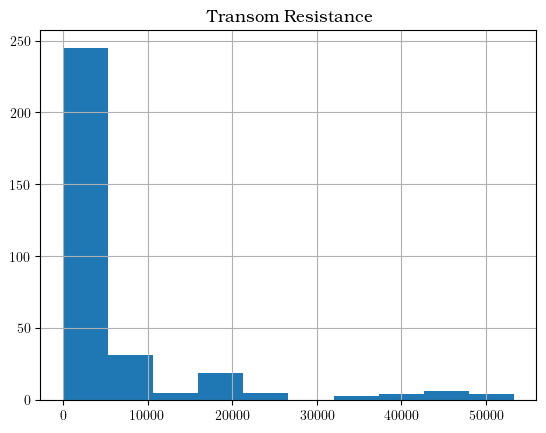

In [95]:
R_tr = dfprog['R_tr']
R_tr.hist()
plt.title("Transom Resistance")
plt.show()

In [96]:
# Model ship correlation resistance

# print("Ratio check to ensure correct formula is used for Holtrop Mennen")

cond_Tf_lwl = [(T_fwd/lwl) <= 0.04 ]
cond_c4 = [T_fwd/lwl]
dfprog['c4'] = np.select(cond_Tf_lwl,cond_c4,0.04)

C_a = 0.00546*(lwl+100)**-0.16 - 0.002 + 0.003*math.sqrt(lwl/7.5)*C_b**4*c2*(0.04-dfprog ['c4'])

dfprog['R_a'] = 0.5*rho_sea*dfprog['stw_pred_ms']**2*C_a*(dfprog['S_bh']+S_app)

print(f"C_a {C_a.mean()}")
print(f"Mean STW {dfprog['stw_pred'].mean():0.2f} kt")
print(f"Correlation allowance resistance {dfprog['R_a'].mean():0.2f} N")


C_a 0.0002698825982860096
Mean STW 17.04 kt
Correlation allowance resistance 46034.32 N


Calculation of Wind speed <br>
- There are two formula, one from Holtrop another one from Blendermann, Blendermann seems to be more reasonable as it considers the wind direction

In [97]:
# Calculate using Holtrop Mennen
A_f = 325.3
dfprog['R_aa_hm'] = 0.5 * rho_air * dfprog['stw_pred_ms']**2 * 0.8 * A_f
print(f"Mean wind resistance Holtrop Mennen {dfprog['R_aa_hm'].mean():0.2f} N")

Mean wind resistance Holtrop Mennen 13537.94 N


In [98]:
# Calculate Additional Resistance, consist of wind resistance and wave resistance
# Calculate Apparent velocities and Apparent Angle 

dfprog['V_aw'] = np.sqrt(dfprog['windspeed']**2 + dfprog['stw_pred_ms']**2 + 2*dfprog['windspeed']*dfprog['stw_pred_ms']*np.cos(np.deg2rad(dfprog['truewinddir'])))

dfprog['awa_c1'] = (dfprog['windspeed']/dfprog['V_aw'])*np.sin(np.deg2rad(dfprog['truewinddir']))

# Epsilon is Apparent Wind Angle AWA

dfprog['epsilon'] = np.rad2deg(np.arcsin(dfprog['awa_c1']))

# Values and method from Blendermann

C_DlAf = 0.45
A_f = 325.3
A_l = 2125.8
C_Dt = 0.9
delta = 0.8
C_Dl = C_DlAf * A_f / A_l
L_bwl = 43.75 # m, acquired from picture

dfprog['Raa_const1'] = (rho_air/2) * dfprog['V_aw']**2 * A_l * C_Dl
dfprog['Raa_const2'] = np.cos(np.deg2rad(dfprog['epsilon']))
dfprog['Raa_const3'] = 1 - (delta/2) * ((1-(C_Dl/C_Dt))*(np.sin(np.deg2rad(2*dfprog['epsilon'])))**2)

dfprog['R_aa'] = dfprog['Raa_const1'] * dfprog['Raa_const2'] / dfprog['Raa_const3'] 

print(f"Mean wind resistance Blendermann {dfprog['R_aa'].mean():0.2f}N")

Mean wind resistance Blendermann 11991.39N


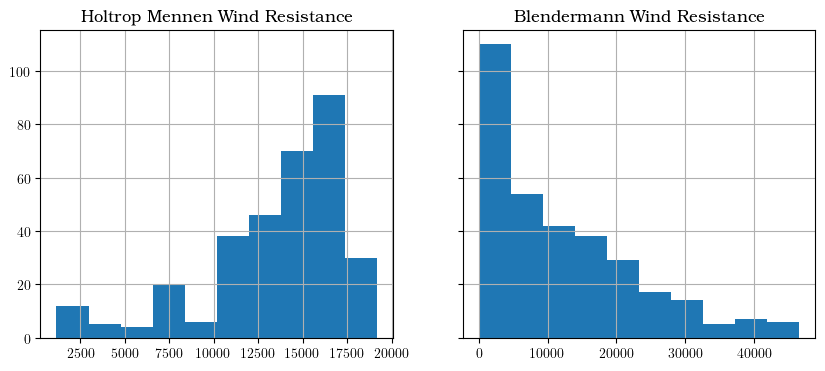

In [99]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
R_aa_hm = dfprog['R_aa_hm']
R_aa_hm.hist()
plt.title("Holtrop Mennen Wind Resistance")
plt.sca(axes[1])
R_aa = dfprog['R_aa']
R_aa.hist()
plt.title("Blendermann Wind Resistance")
plt.ylabel("")
plt.show()

In [100]:
# Calculate Wave Resistance according to STAWAVE-1

Rawl = 1/16 * rho_sea * g * dfprog['windwaveswellheight']**2 * math.sqrt(B/L_bwl)

condwave = [dfprog['truewavedir']<=45]
choicewave = [Rawl]

dfprog['R_awl'] = np.select(condwave,choicewave,0)

print(f"Mean wave resistance STAWAVE-1 {dfprog['R_awl'].mean():0.2f} N")

Mean wave resistance STAWAVE-1 109.71 N


In [101]:
# Calculate total Resistance

dfprog['R_tot'] = dfprog['R_f'] + dfprog['R_app'] + dfprog['R_w'] + dfprog['R_b'] + dfprog['R_a']  + dfprog['R_aa'] + dfprog['R_awl'] + dfprog['R_tr']
# dfprog['R_tot'] = dfprog['R_f'] + dfprog['R_app'] + dfprog['R_w'] + dfprog['R_b'] + dfprog['R_a']  + dfprog['R_aa_hm'] + dfprog['R_awl']

dfprog['R_tot'] = dfprog['R_tot'] / 1e3

df_prog=dfprog.drop(['C_f','Re','Fn_i'],axis=1)

In [102]:
# Calculate Efficiencies

# Diameter value for ship estimated from Bertram 

# D = 0.215*16 #m 
# Revised D, 08.07.23
D = 4 # m, from flyer

# Update C_v formula

dfprog['C_v'] = (dfprog['k1_const']*dfprog['R_f'] + dfprog['R_app'] + dfprog['R_a']) / (0.5*rho_sea*dfprog['stw_pred_ms']**2*(dfprog['S_bh']+S_app))
dfprog['w'] = 0.3095 * C_b + 10*dfprog['C_v']*C_b - (0.23*D)/np.sqrt(B*dfprog['draught']) 
dfprog['t'] = 0.325*C_b - 0.1885*D/np.sqrt(B*dfprog['draught'])
dfprog['eff_h'] = (1-dfprog['t']) / (1-dfprog['w'])
dfprog['eff_r'] = 0.9737 + 0.111*(C_p - 0.225*lcb) - 0.06325*lcb
dfprog['eff_s'] = 0.99 # Set according to holtrop mennen and man
dfprog['eff_o'] = 0.75 # Approximation from Wageningen Line from Breslin94, since Holtrop perform their measurement in Wageningen basin 

dfprog['eff_tot'] = dfprog['eff_h']* dfprog['eff_r']* dfprog['eff_s']*dfprog['eff_o'] # consider sea margin

print(f"Total Efficiency {dfprog['eff_tot'].mean():0.3f} N")

Total Efficiency 0.767 N


In [103]:
# Calculate power and FOC

dfprog['P_b'] = (dfprog['R_tot'] * dfprog['stw_pred_ms'])/dfprog['eff_tot'] # in kW
SFOC = 169.4 # g/kWh, taken from datasheet Waertsilla 8V31
dfprog['FOC'] = (dfprog['P_b'] * SFOC)/1e6 # get FOC t/h

print(f"Average Power {dfprog['P_b'].mean():0.3f} kW")
print(f"Max Power {dfprog['P_b'].max():0.3f} kW")
print(f"Average Fuel Consumption per hour {dfprog['FOC'].mean():0.3f} T")

Average Power 5107.707 kW
Max Power 10337.926 kW
Average Fuel Consumption per hour 0.865 T


In [104]:
dfprog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 119 to 7419
Data columns (total 72 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     322 non-null    float64
 1   waveperiod           322 non-null    float64
 2   surftemp             322 non-null    float64
 3   windwaveswellheight  322 non-null    float64
 4   draught              322 non-null    float64
 5   cog                  322 non-null    float64
 6   heading              322 non-null    float64
 7   windspeed            322 non-null    float64
 8   curspeed             322 non-null    float64
 9   truewinddir          322 non-null    float64
 10  truecurrentdir       322 non-null    float64
 11  truewavedir          322 non-null    float64
 12  sog_act              322 non-null    float64
 13  sog_pred             322 non-null    float64
 14  gamma                322 non-null    float64
 15  nwinddir             322 non-null    

In [105]:
# Drop All intermediate Constants

dfprog_f = dfprog.drop(['Re','C_f','Fr_n','m_4','Fn_i',
                        'C_v','w','t','sog_act','stw_pred_ms','V_aw','awa_c1','epsilon','Raa_const1','Raa_const2','Raa_const3',
                        'k1_const','A_m','A_t','A_bt','sbh_a','sbh_e','sbh_g',
                        'S_bh','c3','c5','m_1','c1','Fn_tr','R_tr','c6','c4'],axis=1)

In [106]:
# dfprog_f.info()

In [107]:
print(dfprog_f.describe())
stats = dfprog_f.describe()

       oceantemperature  waveperiod    surftemp  windwaveswellheight  \
count        322.000000  322.000000  322.000000           322.000000   
mean         287.133146    3.400343  287.256948             0.661506   
std            6.306975    0.965020    4.797442             0.541832   
min          269.606903    1.915993  275.485352             0.073242   
25%          285.292786    2.692099  286.832031             0.272528   
50%          289.505615    3.160003  289.004578             0.474936   
75%          291.391602    3.764453  290.458008             0.788779   
max          294.685303    6.291378  292.665649             2.565230   

          draught         cog     heading   windspeed    curspeed  \
count  322.000000  322.000000  322.000000  322.000000  322.000000   
mean     5.282713  197.436423  189.432992    5.832751    0.092478   
std      0.162420   86.327689   88.499255    3.020207    0.068917   
min      4.754639   82.664990   79.551648    0.441768    0.002006   
25%   

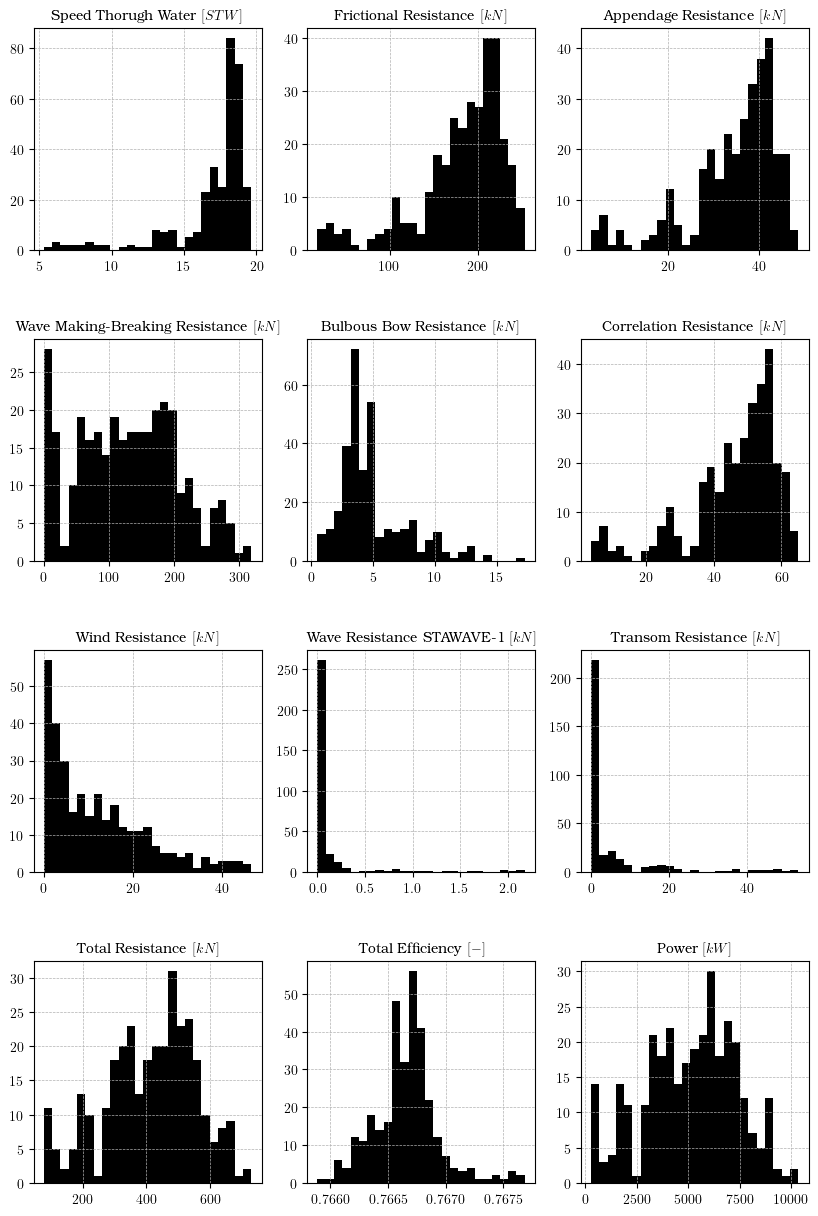

In [108]:
fs = 10

plt.rcParams.update(plt.rcParamsDefault)
# Parameter to plot in nice latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})


stw = dfprog_f['stw_pred']
R_f = dfprog_f['R_f']/1e3
R_app = dfprog_f['R_app']/1e3
R_w = dfprog_f['R_w']/1e3
R_b = dfprog_f['R_b']/1e3
R_tr = dfprog['R_tr']/1e3
R_a = dfprog_f['R_a']/1e3
R_aa = dfprog_f['R_aa']/1e3
# R_aa_hm = dfprog_f['R_aa_hm']/1e3
R_awl = dfprog_f['R_awl']/1e3
R_tot = dfprog_f['R_tot']
eff_h = dfprog_f['eff_h']
eff_tot = dfprog_f['eff_tot']
P_b = dfprog_f['P_b']
FOC = dfprog_f['FOC']



fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

axes[0, 0].hist(stw,bins=25,color='black')
axes[0, 0].set_title(r'Speed Thorugh Water $[STW]$', fontsize=fs)
axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 1].hist(R_f,bins=25,color='black')
axes[0, 1].set_title(r'Frictional Resistance $[kN]$', fontsize=fs)
axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 2].hist(R_app,bins=25,color='black')
axes[0, 2].set_title(r'Appendage Resistance $[kN]$', fontsize=fs)
axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 0].hist(R_w,bins=25,color='black')
axes[1, 0].set_title(r'Wave Making-Breaking Resistance $[kN]$', fontsize=fs)
axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 1].hist(R_b  ,bins=25,color='black')
axes[1, 1].set_title(r'Bulbous Bow Resistance $[kN]$', fontsize=fs)
axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 2].hist(R_a,bins=25,color='black')
axes[1, 2].set_title(r'Correlation Resistance $[kN]$', fontsize=fs)
axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 0].hist(R_aa,bins=25,color='black')
axes[2, 0].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[2, 0].hist(R_aa_hm,bins=25,color='black')
# axes[2, 0].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
# axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 1].hist(R_awl,bins=25,color='black')
axes[2, 1].set_title(r'Wave Resistance STAWAVE-1 $[kN]$', fontsize=fs)
axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 2].hist(R_tr,bins=25,color='black')
axes[2, 2].set_title(r'Transom Resistance $[kN]$', fontsize=fs)
axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 0].hist(R_tot,bins=25,color='black')
axes[3, 0].set_title(r'Total Resistance $[kN]$', fontsize=fs)
axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 0].hist(eff_h,bins=25,color='black')
# axes[3, 0].set_title(r'Hull Efficiency $[-]$', fontsize=fs)
# axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 1].hist(eff_tot,bins=25,color='black')
axes[3, 1].set_title(r'Total Efficiency $[-]$', fontsize=fs)
axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 2].hist(P_b,bins=25,color='black')
axes[3, 2].set_title(r'Power $[kW]$', fontsize=fs)
axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[4, 1].hist(FOC,bins=25,color='black')
# axes[4, 1].set_title(r'Fuel Consumption $[t/h]$', fontsize=fs)
# axes[4, 1].grid(True,linestyle = '--', linewidth = 0.5)

fig.subplots_adjust(hspace=0.4)
plt.show()

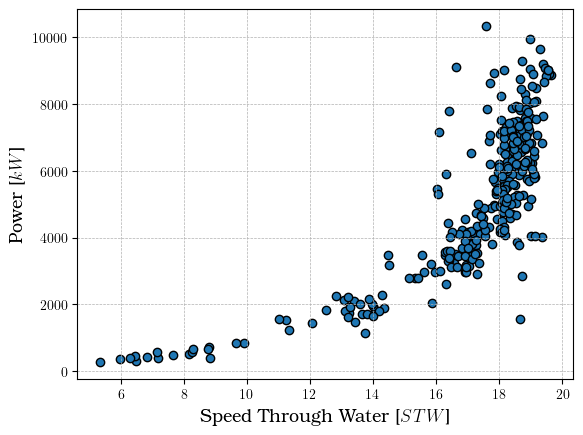

In [109]:
plt.scatter(stw,P_b,edgecolors='black')
plt.xlabel(r'Speed Through Water [$STW$]', fontsize=13)
plt.ylabel(r'Power [$kW$]', fontsize=13)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()


In [110]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degree=3
X_seq = np.linspace(min(stw), max(stw), 322).reshape(-1, 1)
# X_seq = np.linspace(min(stw), max(stw), 322).reshape(-1, 1)
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(stw.values.reshape(-1,1),P_b)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

[1607.28811318 -154.47477861    5.44547203]
-5051.518645358006


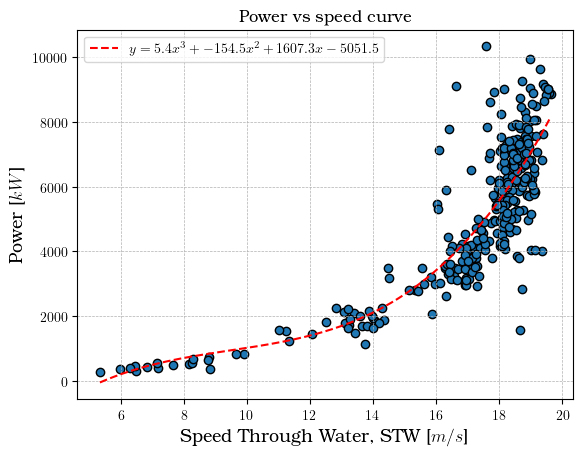

In [111]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(stw.values.reshape(-1,1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, P_b)
coef_3 = poly_reg_model.coef_[2]
coef_2 = poly_reg_model.coef_[1]
coef_1 = poly_reg_model.coef_[0]
coef_0 = poly_reg_model.intercept_
print(poly_reg_model.coef_)
print(poly_reg_model.intercept_)


import matplotlib.pyplot as plt
plt.figure()
plt.scatter(stw,P_b,edgecolors='black')
# plt.plot(X_seq,Y_seq,color="green",ls='--')
plt.plot(X_seq,polyreg.predict(X_seq),color="red",ls='--',label=rf'$y = {coef_3:.1f}x^3 + {coef_2:.1f}x^2 +{coef_1:.1f}x  {coef_0:.1f}$')
plt.title("Power vs speed curve")
plt.xlabel(r'Speed Through Water, STW [$m/s$]', fontsize=13)
plt.ylabel(r'Power [$kW$]', fontsize=13)
# plt.xlim(6,17.7)
# plt.ylim(200,5000)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

In [112]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(stw.values.reshape(-1,1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, P_b)
print(poly_reg_model.coef_)
print(poly_reg_model.intercept_)

[1607.28811318 -154.47477861    5.44547203]
-5051.518645358006


4th Degree

[-1.15760844e+03  1.90621645e+02 -1.26948842e+01  3.42486492e-01]
2718.4821561349345


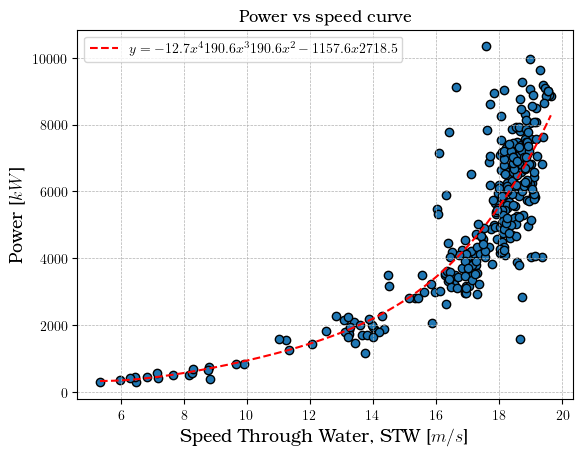

[-1.15760844e+03  1.90621645e+02 -1.26948842e+01  3.42486492e-01]
2718.4821561349345


In [113]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degree=4
X_seq = np.linspace(min(stw), max(stw), 351).reshape(-1, 1)
# X_seq = np.linspace(min(stw), max(stw), 322).reshape(-1, 1)
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(stw.values.reshape(-1,1),P_b)

poly = PolynomialFeatures(degree=4, include_bias=False)
poly_features = poly.fit_transform(stw.values.reshape(-1,1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, P_b)
coef_4 = poly_reg_model.coef_[3]
coef_3 = poly_reg_model.coef_[2]
coef_2 = poly_reg_model.coef_[1]
coef_1 = poly_reg_model.coef_[0]
coef_0 = poly_reg_model.intercept_
print(poly_reg_model.coef_)
print(poly_reg_model.intercept_)


import matplotlib.pyplot as plt
plt.figure()
plt.scatter(stw,P_b,edgecolors='black')
# plt.plot(X_seq,Y_seq,color="green",ls='--')
plt.plot(X_seq,polyreg.predict(X_seq),color="red",ls='--',label=rf'$y = {coef_3:.1f}x^4 {coef_2:.1f}x^3  {coef_2:.1f}x^2 {coef_1:.1f}x  {coef_0:.1f}$')
plt.title("Power vs speed curve")
plt.xlabel(r'Speed Through Water, STW [$m/s$]', fontsize=13)
plt.ylabel(r'Power [$kW$]', fontsize=13)
# plt.xlim(6,17.7)
# plt.ylim(200,5000)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

poly = PolynomialFeatures(degree=4, include_bias=False)
poly_features = poly.fit_transform(stw.values.reshape(-1,1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, P_b)
print(poly_reg_model.coef_)
print(poly_reg_model.intercept_)

In [114]:
# m = 100
# X = np.linspace(6, max(stw), 322)
# y =  3.33939517 * X**3  -76.51155702*X**2 + 723.80185073*X + 100

# sns.regplot(x=X,
#             y=y,
#             order=3,
#             line_kws={'color':'red'}
#            );

# plt.show()

In [115]:
def foc_fun(stw,T_dyn,windspeed,truewindir,H_s,truewavedir):
    # Ship Information, that are readily available in ship specification
    loa = 158 # ship overall length
    lwl = 144.8 # ship waterline length, m
    lpp = 0.97*lwl # ship perpendicular length , m, according to information
    B = 24.5 # Ship breadth, m
    depth = 13.8 # Ship depth. m
    T_n = 5.85 # Nominal max draught , m
    # T_n = 5.7 # Nominal design draught , m
    dwt = 5110 # ship dead weight , t
    V_n = 17.7 # ship design speed, knots

    # Environmental Constants

    g = 9.805 # gravity, kg/ms^2 
    rho_sea = 1025 # kg/m3
    nu_sea = 0.00000118 # Dynamic viscosity of sea m^2/s
    rho_air = 1.25 # density air 

    # Any other additional ship parameters beyond here are approximated based on literature review.

    # Convert STW to m/s, stw with only current correction

    stw_ms = stw / 1.94384

    # Switch between actual and predicted here 
    # Calculation for Block coefficient,C_b, according to Schneekluth and Bertram 1998
    # Then Froude number is required

    V_n = 17.7/1.94384
    Fr_n = V_n / math.sqrt(g*lpp)
    print(f"Froude Number {Fr_n:0.4f}")

    C_b = -4.22 + 27.8*math.sqrt(Fr_n) - 39.1*Fr_n + 46.6*(Fr_n)**3
    print(f"C_b {C_b:0.4f}")

    # calculation for midship section coefficient, C_m according to Jensen from Birk

    C_m = 1 / (1+(1-C_b)**3.5)
    print(f"C_m {C_m:0.4f}")

    # prismatic coefficient C_p can be calculated according to Biran

    C_p = C_b/C_m 
    print(f"C_p {C_p:0.4f}")

    # Displacement calculation according to Barras 

    dsp = C_b * lwl * B * T_n

    print(f"dsp {dsp:0.4f} m^3")

    # coefficient c14 to account for stern shape according to holtrop mennen

    C_stern = 10 # assume u shaped stern
    c14 = 1 + 0.011*C_stern 
    print(f"c14 {c14:0.4f}")

    # Calculate length of run according to holtrop mennen

    # lcb = -2/100 # according to Barras
    lcb = -(0.44*Fr_n - 0.094) # according to Guldhammer and Harvald

    # L in holtrop mennen is lwl

    lr = lwl*(1-C_p+(0.06*C_p*lcb/(4*C_p-1)))
    print(f"lr {lr:0.4f} m")

    # now the (1+k1) can be calculated

    k1a = 0.487118*c14*(B/lwl)**1.06806
    k1b = (T_dyn/lwl)**0.46106
    k1c = (lwl/lr)**0.121563
    k1d = (lwl**3/dsp)**0.36486
    k1e = (1-C_p)**-0.604247

    k1_const = 0.93 + k1a*k1b*k1c*k1d*k1e
    print(f"k1_const {k1_const.mean():0.4f}")

    # Calculate Reynold number and Coefficient of Friction C_f. Here, the C_f will be dynamic and depend on the velocity of the ship

    Re =( stw_ms * lwl ) / nu_sea
    C_f = 0.075 / (np.log10(Re-2)**2)

    print(f"Mean Reynold Number {Re.mean():0.2f}")
    print(f"Mean Coefficient of friction {C_f.mean():0.6f}")
    
    # Calculate the appendage area of bare hull S_bh
    # Formula according to Holtrop Mennen

    # Calculate the waterplane area coefficient 
    # Formula according to Schneekluth and Bertram

    C_wp = (1+2*C_b)/3
    print(f"C_wp {C_wp:0.4f}")

    # Calculate transverse bulb area A_bt, Transom area A_t and immersed midship section area A_m according to Kim 2019

    # dfprog['A_m'] = B*dfprog['draught']*C_m
    A_m = dsp/(lpp*C_p)
    A_t = 0.051 * A_m
    A_bt = 0.085*A_m # From approximation of Kracht78, Similar to Charcalis
    print(f"A_m {A_m:0.2f} m^2")
    print(f"A_t {A_t:0.2f} m^2")
    print(f"A_bt {A_bt:0.2f} m^2")

    sbh_a = lwl*(2*T_dyn+B)*math.sqrt(C_m)
    sbh_b = 0.453
    sbh_c = 0.4425*C_b
    sbh_d = 0.2862*C_m
    sbh_e = 0.003467*(B/T_dyn)
    sbh_f = 0.3696*C_wp
    sbh_g = 2.38*A_bt/C_b

    S_bh = sbh_a*(sbh_b+sbh_c-sbh_d+sbh_e+sbh_f)+sbh_g

    print(f"S_bh {S_bh.mean():0.2f} m^2")

    # Calculate R_f

    R_f = 0.5 * rho_sea * stw_ms**2 * C_f * S_bh * k1_const

    print(f"Mean STW {stw.mean():0.2f} kt")
    print(f"Frictional Resistance {R_f.mean():0.2f} N")
    
    # Calculate resistance due to appendage

    # Assume S_app
    # Taken from Holtrop Mennen worked example
    # S_app = 50 # m^2 

    # Calculation of appendage area according to Hollenbach method, the formula is for twin screw ship

    # Lower limit
    S_app_lo = S_bh.mean()*(0.028+0.01*math.exp(-(lpp*T_n)/1000))

    # Upper limit
    S_app_hi = S_bh.mean()*(0.0325+0.045*math.exp(-(lpp*T_n)/1000))

    print(f"S_app between {S_app_lo:.02f} and {S_app_hi:.02f} according to Hollenbach")

    # The following appendage area are scaled from the picture of the ship
    # Constant k here means (1+k_2) !

    D_shaft = 0.55 # m, approx
    l_shaft = 13.54 # m, approx

    S_app_shaft = math.pi * D_shaft * l_shaft
    k2_shaft = 2   

    h_rudder = 4.06 #m, approx
    B_rudder = 1.99 #m, approx
    S_app_rudder = 2 * h_rudder * B_rudder #m, two side
    k2_rudder = 3

    h_skeg = 4.41 #m, approx
    l_skeg = 26.23 #m, approx
    S_app_skeg =  h_skeg * l_skeg #two side
    k2_skeg = 0.75

    S_app = S_app_shaft + S_app_rudder + S_app_skeg

    k2_const = (k2_shaft*S_app_shaft + k2_rudder*S_app_rudder + k2_skeg*S_app_skeg)/S_app

    print(f"Wetted area of hull is {S_bh.mean():0.2f}")
    print(f"(1+k2) equivalent {k2_const:0.2f}")
    print(f"Total Appendage area is {S_app:0.2f}")
    # from holtrop mennen, take case of twin screw
    # k2_const = 2.8

    # Add resistance due to Bow Thrusters

    d_th = 2.15 #m, approx

    # Use formula from Hollenach
    C_dth = 0.003 + 0.003*((10*d_th/T_n)-1)
    # C_dth = 0.003 # The picture shows that the thruster are fairly parallel to midship area
    # There are two bow thruster in this ship
    R_th = rho_sea*stw_ms**2*math.pi*d_th**2*C_dth
    print(f"Friction due to bow thrusters {R_th.mean():0.2f} N")

    R_app = (0.5 * rho_sea * stw_ms**2 * C_f * S_app *k2_const) + 2*R_th
    print(f"Mean STW {stw.mean():0.2f} kt")
    print(f"Appendage Friction {R_app.mean():0.2f} N")

    # Calculate wave-making and wave-breaking resistance

    print("Ratio check to ensure correct formula is used for Holtrop Mennen")
    print(f"B/lwl = {B/lwl:0.2f}")
    print(f"lwl^3/displacemt = {lwl**3/dsp:0.2f}")
    print(f"C_p = {C_p:0.4f}")


    c7 = B/lwl
    T_fwd = T_dyn # See reasoning from Rakke16 
    h_b = 0.6*T_n # must not exceed 0.6 T_f, here T_n = T_f (design), reasong and coefficient value taken from Rakke

    # All formulas here are listed by Holtrop Mennen

    c3 = 0.56 * A_bt**1.5 / (B*T_dyn*(0.31*np.sqrt(A_bt)+T_fwd-h_b))
    c2 = np.exp(-1.89*np.sqrt(c3))
    c5 = 1 - 0.8*(A_t/(B*T_dyn*C_m))
    lambda_const = (1.446 * C_p) - 0.03*(lwl/B)
    c16 = 8.07981*C_p - 13.8673*C_p**2 + 6.984388*C_p**3
    m_1 = 0.0140407 * (lwl/T_dyn) - 1.75254*(dsp**(1/3)/lwl) -  4.79323*(B/lwl) - c16
    c15 = -1.69385

    # Use dynamic Froude here to refect the actual resistance due to ship movement 

    Fr_n_dyn = stw_ms / math.sqrt(g*lpp)
    # Updated formula use m_4
    m4 = 0.4 * c15 * np.exp(-0.034*Fr_n_dyn **-3.29)

    i_e = 1 + 89*math.exp(-(lwl/B)**0.80856*(1-C_wp)**0.30484*(1-C_p-0.0225*lcb)**0.6367*(lr/B)**0.34574*((100*dsp)/lwl**3)**0.16302)
    c1 = 2223105 * c7**3.78613 * (T_dyn/B)**1.07961*(90-i_e)**-1.37565
    d = -0.9

    # Use updated formula with m4

    R_w = c1*c2*c5*dsp*g*rho_sea*np.exp(m_1*Fr_n_dyn **d+m4*np.cos(lambda_const*Fr_n_dyn **-2))

    print(f"Mean STW {stw.mean():0.2f} kt")
    print(f"Wave resistance {R_w.mean():0.2f} N")

    # Calculate Resistance due to Bulbous Bow
    # Calculate effect of forward sinkage h_f and local wave height at bow h_w

    h_f = C_p * C_m * (136-316-3*Fr_n_dyn)*Fr_n_dyn**3
    h_w = (i_e * stw_ms **2) / (400*g)

    P_b = 0.56*np.sqrt(A_bt)/(T_fwd-1.5*h_b)
    Fn_i = stw_ms / np.sqrt(g*(T_fwd-h_b-0.25*np.sqrt(A_bt))+0.15*stw_ms**2)
    # Updated Fn_i
    # Fn_i = stw_ms / np.sqrt(g*(T_fwd-h_b-0.25*np.sqrt(A_bt)+h_f+h_w))
    R_b = 0.11 * np.exp(-3*P_b**-2)*Fn_i**3*A_bt**1.5*rho_sea*g/(1+Fn_i**2)
    # Update R_b
    # dfprog['R_b'] = 0.11 * rho_sea * g * np.sqrt(dfprog['A_bt'])**3 * ((dfprog['Fn_i']**3)/(1 + dfprog['Fn_i']**2)) * np.exp(-3*P_b**-2)

    print(f"Emergence of bulb Pb {P_b.mean():0.4f}")
    print(f"Immersion Froude number Fn_i {Fn_i.mean():0.2f}")
    print(f"Mean STW {stw.mean():0.2f} kt")
    print(f"Resistance due to bulbous bow {R_b.mean():0.2f} N")    

    #Calculate Transom Resistance 

    Fn_tr = stw_ms / np.sqrt(2*g*A_t/(B+(B*C_wp)))
    print(f"Froude for Transom {Fn_tr.mean():0.4f}")

    # Use condition to calculate Froude due to transom

    cond_Fn_tr = [Fn_tr < 5 ]
    cond_c6 = [0.2*(1-0.2*Fn_tr)]

    c6 = np.select(cond_Fn_tr,cond_c6,0)
    R_tr = 0.5*rho_sea*10**2*A_t*c6
    print(f"Mean STW {stw.mean():0.2f} kt")
    print(f"Resistance due to transom {R_tr.mean():0.2f} N")

    # Model ship correlation resistance

    print("Ratio check to ensure correct formula is used for Holtrop Mennen")

    cond_Tf_lwl = [(T_fwd/lwl) <= 0.04 ]
    cond_c4 = [T_fwd/lwl]
    c4 = np.select(cond_Tf_lwl,cond_c4,0.04)

    C_a = 0.00546*(lwl+100)**-0.16 - 0.002 + 0.003*math.sqrt(lwl/7.5)*C_b**4*c2*(0.04-c4)

    R_a = 0.5*rho_sea*stw_ms**2*C_a*(S_bh+S_app)

    print(f"C_a {C_a.mean()}")
    print(f"Mean STW {stw.mean():0.2f} kt")
    print(f"Correlation allowance resistance {R_a.mean():0.2f} N")

    # Calculate Additional Resistance, consist of wind resistance and wave resistance
    # Calculate Apparent velocities and Apparent Angle 

    V_aw = np.sqrt(windspeed**2 + stw_ms**2 + 2*windspeed*stw_ms*np.cos(np.deg2rad(truewindir)))

    awa_c1 = (windspeed/V_aw)*np.sin(np.deg2rad(truewindir))

    # Epsilon is Apparent Wind Angle AWA

    epsilon = np.rad2deg(np.arcsin(awa_c1))

    # Values and method from Blendermann

    C_DlAf = 0.45
    A_f = 325.3
    A_l = 2125.8
    C_Dt = 0.9
    delta = 0.8
    C_Dl = C_DlAf * A_f / A_l
    L_bwl = 43.75 # m, acquired from picture

    Raa_const1 = (rho_air/2) * V_aw**2 * A_l * C_Dl
    Raa_const2 = np.cos(np.deg2rad(epsilon))
    Raa_const3 = 1 - (delta/2) * ((1-(C_Dl/C_Dt))*(np.sin(np.deg2rad(2*epsilon)))**2)

    R_aa = Raa_const1 * Raa_const2 / Raa_const3 

    print(f"Mean wind resistance Blendermann {R_aa.mean():0.2f}N")

    # Calculate Wave Resistance according to STAWAVE-1

    Rawl = 1/16 * rho_sea * g * H_s**2 * math.sqrt(B/L_bwl)

    condwave = [truewavedir<=45]
    choicewave = [Rawl]

    R_awl = np.select(condwave,choicewave,0)

    print(f"Mean wave resistance STAWAVE-1 {R_awl.mean():0.2f} N")

    # Calculate Efficiencies

    # Diameter value for ship estimated from Bertram 

    # D = 0.215*16 #m 
    # Revised D, 08.07.23
    D = 4 # m, from flyer

    # Update C_v formula

    C_v = (k1_const*R_f + R_app + R_a) / (0.5*rho_sea*stw_ms**2*(S_bh+S_app))
    w = 0.3095 * C_b + 10*C_v*C_b - (0.23*D)/np.sqrt(B*T_dyn) 
    t = 0.325*C_b - 0.1885*D/np.sqrt(B*T_dyn)
    eff_h = (1-t) / (1-w)
    eff_r = 0.9737 + 0.111*(C_p - 0.225*lcb) - 0.06325*lcb
    eff_s = 0.99 # Set according to holtrop mennen and man
    eff_o = 0.75 # Approximation from Wageningen Line from Breslin94, since Holtrop perform their measurement in Wageningen basin 

    eff_tot = eff_h* eff_r* eff_s*eff_o # consider sea margin

    print(f"Total Efficiency {eff_tot.mean():0.3f} N")

    # Calculate power and FOC

    P_b = (R_tot * stw_ms)/eff_tot # in kW
    SFOC = 169.4 # g/kWh, taken from datasheet Waertsilla 8V31
    FOC = (P_b * SFOC)/1e6 # get FOC t/h

    print(f"Average Power {P_b.mean():0.3f} kW")
    print(f"Max Power {P_b.max():0.3f} kW")
    print(f"Average Fuel Consumption per hour {FOC.mean():0.3f} T")

    return R_f,R_app,R_w,R_b,R_tr,R_a,R_aa,R_awl,eff_tot,P_b,FOC







In [116]:
Rf_pred,R_app_pred,R_w_pred,R_b_pred,R_tr_pred,R_a_pred,R_aa_pred,R_awl_pred,eff_tot_pred,P_b_pred,FOC_pred = foc_fun(dfprog['stw_pred'],dfprog['draught'],dfprog['windspeed'],dfprog['truewinddir'],dfprog['windwaveswellheight'],dfprog['truewavedir'])

Froude Number 0.2454
C_b 0.6451
C_m 0.9741
C_p 0.6623
dsp 13388.8120 m^3
c14 1.1100
lr 48.8488 m
k1_const 1.2102
Mean Reynold Number 1075925314.16
Mean Coefficient of friction 0.000921
C_wp 0.7634
A_m 143.93 m^2
A_t 7.34 m^2
A_bt 12.23 m^2
S_bh 3843.36 m^2
Mean STW 17.04 kt
Frictional Resistance 172445.32 N
S_app between 124.51 and 200.96 according to Hollenbach
Wetted area of hull is 3843.36
(1+k2) equivalent 1.17
Total Appendage area is 155.23
Friction due to bow thrusters 12949.01 N
Mean STW 17.04 kt
Appendage Friction 32643.57 N
Ratio check to ensure correct formula is used for Holtrop Mennen
B/lwl = 0.17
lwl^3/displacemt = 226.76
C_p = 0.6623
Mean STW 17.04 kt
Wave resistance 94814.90 N
Emergence of bulb Pb 21.1421
Immersion Froude number Fn_i 1.93
Mean STW 17.04 kt
Resistance due to bulbous bow 70331.07 N
Froude for Transom 4.8036
Mean STW 17.04 kt
Resistance due to transom 4988.50 N
Ratio check to ensure correct formula is used for Holtrop Mennen
C_a 0.0002694806327505775
Mean S

In [117]:
Rf_act,R_app_act,R_w_act,R_b_act,R_tr_act,R_a_act,R_aa_act,R_awl_act,eff_tot_act,P_b_act,FOC_act = foc_fun(dfprog['stw_act'],dfprog['draught'],dfprog['windspeed'],dfprog['truewinddir'],dfprog['windwaveswellheight'],dfprog['truewavedir'])

Froude Number 0.2454
C_b 0.6451
C_m 0.9741
C_p 0.6623
dsp 13388.8120 m^3
c14 1.1100
lr 48.8488 m
k1_const 1.2102
Mean Reynold Number 1102512169.68
Mean Coefficient of friction 0.000920
C_wp 0.7634
A_m 143.93 m^2
A_t 7.34 m^2
A_bt 12.23 m^2
S_bh 3843.36 m^2
Mean STW 17.46 kt
Frictional Resistance 181371.10 N
S_app between 124.51 and 200.96 according to Hollenbach
Wetted area of hull is 3843.36
(1+k2) equivalent 1.17
Total Appendage area is 155.23
Friction due to bow thrusters 13660.07 N
Mean STW 17.46 kt
Appendage Friction 34415.25 N
Ratio check to ensure correct formula is used for Holtrop Mennen
B/lwl = 0.17
lwl^3/displacemt = 226.76
C_p = 0.6623
Mean STW 17.46 kt
Wave resistance 119355.16 N
Emergence of bulb Pb 21.1421
Immersion Froude number Fn_i 1.94
Mean STW 17.46 kt
Resistance due to bulbous bow 71151.30 N
Froude for Transom 4.9223
Mean STW 17.46 kt
Resistance due to transom 5059.28 N
Ratio check to ensure correct formula is used for Holtrop Mennen
C_a 0.0002694806327505775
Mean 

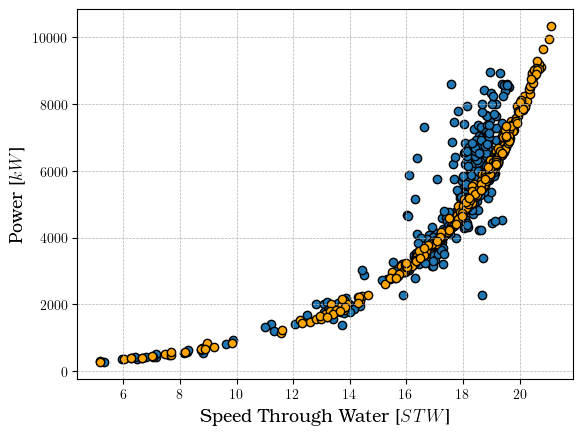

In [118]:
plt.scatter(dfprog['stw_pred'],P_b_pred,edgecolors='black',c='#1f77b4')
plt.scatter(dfprog['stw_act'],P_b_act,edgecolors='black',c='orange')
plt.xlabel(r'Speed Through Water [$STW$]', fontsize=13)
plt.ylabel(r'Power [$kW$]', fontsize=13)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

In [119]:
stw_pred = dfprog['stw_pred']
stw_act = dfprog['stw_act']

[ 3.53902126e-01 -1.33616927e+01  2.02453198e+02 -1.24497204e+03
  2.95173543e+03]
[ 4.05151733e-01 -1.68166085e+01  2.73178345e+02 -1.81457947e+03
  4.50240344e+03]


C:\Users\Wafi\AppData\Local\Temp\ipykernel_11208\603031666.py:18: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(Xp, Yp,marker='x',linewidths=.5,edgecolors='black',c='gray',label = 'Predicted STW',s=12 )


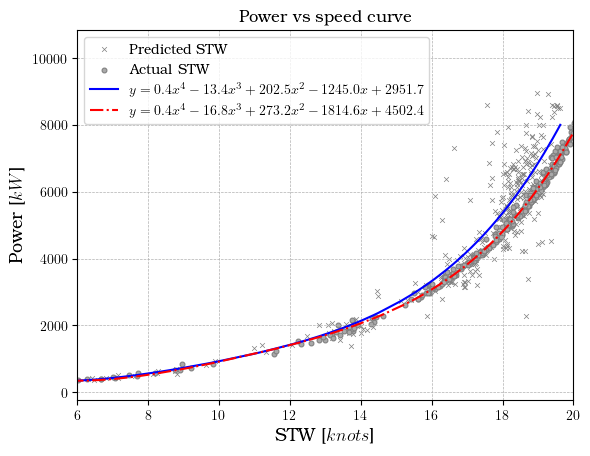

In [146]:
import numpy as np
from matplotlib import pyplot as plt
Xp = stw_pred
Yp = P_b_pred

Xa = stw_act
Ya = P_b_act

coefs_pred = np.polyfit(Xp, Yp, 4)
coefs_act = np.polyfit(Xa, Ya, 4)

print(coefs_pred)
print(coefs_act)

p_pred = np.poly1d(coefs_pred)
p_act = np.poly1d(coefs_act)

plt.scatter(Xp, Yp,marker='x',linewidths=.5,edgecolors='black',c='gray',label = 'Predicted STW',s=12 )
plt.scatter(Xa, Ya,marker='o',linewidths=.8,edgecolors='gray',c='darkgray', label = 'Actual STW',s=12 )

sorted_pred= np.sort(Xp)
sorted_act= np.sort(Xa)

plt.plot(sorted_pred, p_pred(sorted_pred), linestyle = '-',color = 'b',
         label=rf'$y = {coefs_pred[0]:.1f}x^4 {coefs_pred[1]:.1f}x^3 + {coefs_pred[2]:.1f}x^2 {coefs_pred[3]:.1f}x + {coefs_pred[4]:.1f}$') #p(X) evaluates the polynomial at X
plt.plot(sorted_act, p_act(sorted_act), linestyle = "-." , color = 'red',
         label=rf'$y = {coefs_act[0]:.1f}x^4 {coefs_act[1]:.1f}x^3 + {coefs_act[2]:.1f}x^2 {coefs_act[3]:.1f}x + {coefs_act[4]:.1f}$') #p(X) evaluates the polynomial at X
plt.title("Power vs speed curve")
plt.xlabel(r'STW [$knots$]', fontsize=13)
plt.ylabel(r'Power [$kW$]', fontsize=13)
plt.xlim(6,20)
# plt.ylim(200,5000)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()


[-1.24497204e+03  2.02453198e+02 -1.33616927e+01  3.53902126e-01]
2951.735430604578
[-1.15753948e+03  1.90612494e+02 -1.26943727e+01  3.42476398e-01]
2718.3000292017796


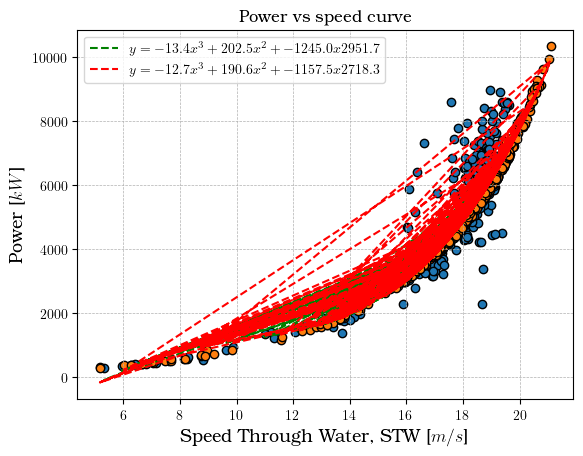

In [121]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degree=3
# X_seq_pred = np.linspace(min(stw_pred), max(stw_pred), 322).reshape(-1, 1)
# X_seq = np.linspace(min(stw), max(stw), 322).reshape(-1, 1)
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())

polyreg.fit(stw_pred.values.reshape(-1,1),P_b_pred)
polyreg.fit(stw_act.values.reshape(-1,1),P_b_act)

X_seq_pred = np.linspace(min(stw_pred), max(stw_pred), 322).reshape(-1, 1)
X_seq_act = np.linspace(min(stw_act), max(stw_act), 322).reshape(-1, 1)


poly = PolynomialFeatures(degree=3, include_bias=False)
poly_reg_model = LinearRegression()

poly_features_pred = poly.fit_transform(stw_pred.values.reshape(-1,1))
poly_model_pred = poly_reg_model.fit(poly_features, P_b_pred)
coef_3p = poly_model_pred.coef_[2]
coef_2p = poly_model_pred.coef_[1]
coef_1p = poly_model_pred.coef_[0]
coef_0p = poly_model_pred.intercept_
print(poly_model_pred.coef_)
print(poly_model_pred.intercept_)

poly_features_act = poly.fit_transform(stw_act.values.reshape(-1,1))
poly_model_act  = poly_reg_model.fit(poly_features, P_b_act)
coef_3a = poly_model_act.coef_[2]
coef_2a = poly_model_act.coef_[1]
coef_1a = poly_model_act.coef_[0]
coef_0a = poly_model_act.intercept_
print(poly_model_act.coef_)
print(poly_model_act.intercept_)


import matplotlib.pyplot as plt
plt.figure()
plt.scatter(stw_pred,P_b_pred,edgecolors='black')
plt.scatter(stw_act,P_b_act,edgecolors='black')
plt.plot(stw_pred,polyreg.predict(stw_pred.values.reshape(-1,1)),color="green",ls='--',label=rf'$y = {coef_3p:.1f}x^3 + {coef_2p:.1f}x^2 +{coef_1p:.1f}x  {coef_0p:.1f}$')
plt.plot(stw_act,polyreg.predict(stw_act.values.reshape(-1,1)),color="red",ls='--',label=rf'$y = {coef_3a:.1f}x^3 + {coef_2a:.1f}x^2 +{coef_1a:.1f}x  {coef_0a:.1f}$')
plt.title("Power vs speed curve")
plt.xlabel(r'Speed Through Water, STW [$m/s$]', fontsize=13)
plt.ylabel(r'Power [$kW$]', fontsize=13)
# plt.xlim(6,17.7)
# plt.ylim(200,5000)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

In [122]:
# stw_pred.to_csv('stw_pred.csv')
# stw_act.to_csv('stw_act.csv')
# P_b_pred.to_csv('P_b_pred.csv')
# P_b_act.to_csv('P_b_act.csv')